In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
from astropy.cosmology import FlatLambdaCDM

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [36]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18,
                     "xtick.minor.top":True, "ytick.minor.right":True,
                     "xtick.minor.visible": True,
                     "ytick.minor.visible": True})

In [314]:
# defining color palette for plotting
palette = {"low":"olive", "high":"salmon", 
           "ex1":"tab:cyan", "ex2":"tab:purple",
           "lower":"#2C1D11", "upper":"#464646",
          }   
lw = {"lower":3,"upper":2}
        

# Import data

In [4]:
f = h5py.File(f"{paths.path_data}/hail-mary/orbitdata_40.hdf5",'r')
low = {}
for key, val in f.items():
    low[key] = np.array(val)
f.close()

f = h5py.File(f"{paths.path_data}/hail-mary/snapshot_data.hdf5",'r')
convert = {}
for key, val in f.items():
    convert[key] = np.array(val)
f.close()

## Create Interpolation data

In [5]:
def create_interp(data, convert, num_samples=10000):
    # first, create interpolated conversion file so I have a list of redshifts and lookback times
    convert_interp = {}
    convert_interp["Lookback Time Interp"] = np.linspace(convert['Lookback Time'][0],convert['Lookback Time'][-1],num_samples)

    # interpolating Redshift along with Lookback Time:
    convert_interp["Redshift Interp"] = np.interp(convert_interp["Lookback Time Interp"][::-1], xp=convert['Lookback Time'][::-1], fp=convert['Redshift'][::-1])[::-1]

    # define the times that I am inputing with the data, and the interpolated 
    # time array where the interpolated data is returned
    times = convert['Lookback Time'][::-1]
    times_interp = convert_interp["Lookback Time Interp"][::-1]
    
    interp_dict = data.copy()
    interp_dict['Separations Interp'] = (np.zeros((len(data['Separations']),num_samples)))
    interp_dict['Separations Interp'].fill(np.nan)
    interp_dict['SeparationsComoving Interp'] = np.zeros((len(data['SeparationsComoving']),num_samples))
    interp_dict['SeparationsComoving Interp'].fill(np.nan)
    interp_dict['SeparationsScaled Interp'] = np.zeros((len(data['SeparationsScaled']),num_samples))
    interp_dict['SeparationsScaled Interp'].fill(np.nan)

    # complete interpolation of all separation values for each pair individually 
    # note that np.interp requires monotonically increasing x, hence the [::-1]
    for i in range(len(data['PairKey'])):
        seps = data['Separations'][i][::-1]
        comov = data['SeparationsComoving'][i][::-1]
        scaled = data['SeparationsScaled'][i][::-1]

        seps_interp = np.interp(times_interp, xp=times, fp=seps)[::-1]
        comov_interp = np.interp(times_interp, xp=times, fp=comov)[::-1]
        scale_interp = np.interp(times_interp, xp=times, fp=scaled)[::-1]

        interp_dict['Separations Interp'][i,:] = seps_interp
        interp_dict['SeparationsComoving Interp'][i,:] = comov_interp
        interp_dict['SeparationsScaled Interp'][i,:] = scale_interp
        
    
    return interp_dict, convert_interp


In [6]:
low_interp, convert_interp = create_interp(low, convert)

In [8]:
ind_in_convert = []
for i in convert_interp['Lookback Time Interp']:
    ind_in_convert.append(np.where((i - convert["Lookback Time"])<=0)[0][-1])

ind_in_convert = np.array(ind_in_convert)
_, ind_in_interp = np.unique(ind_in_convert,return_index=True)

## Add post-infall flag

In [163]:
# let's try to be smart about this ~ 
infall = np.array(np.triu(np.zeros((100,100))+1),dtype='bool')
low["PostInfall"] = infall[low['InfallSnapshot']]

infall_interp = np.array(np.triu(np.zeros((10000,10000))+1),dtype='bool')
low_interp["PostInfall"] = infall_interp[ind_in_interp[low['InfallSnapshot']]]



# Cumulative example 1 

In [323]:
sample = 55 

times = convert['Lookback Time']
seps = low['Separations'][sample]
post = low['PostInfall'][sample]
time_merge = convert['Lookback Time'][low['MergeSnapshot'][sample]]

premerge = convert['Lookback Time'] > time_merge

post_interp = low_interp['PostInfall'][sample]
times_interp = convert_interp["Lookback Time Interp"]
pre_interp = times_interp > time_merge
seps_interp = low_interp['Separations Interp'][sample]

times_masked = times_interp[post_interp&pre_interp]
seps_masked = seps_interp[post_interp&pre_interp]

seps_lower = np.where(seps_masked>=10,10,np.nan)
seps_75 = np.where( (seps_masked<=75 ) & (seps_masked>=10), seps_masked, np.nan)
seps_150 = np.where( (seps_masked<=150 ) & (seps_masked>=10), seps_masked, np.nan)

elapsed_interp = np.concatenate((np.abs(np.diff(times_masked)),[0]))

bins = np.arange(10,200,5)
vals, edges = np.histogram(seps_masked,bins=bins,weights=elapsed_interp)
val_sum = np.cumsum(vals)

upper_75 = val_sum[edges[:-1]<=75]
edges_75 = edges[edges<=75]
upper_150 = val_sum[edges[:-1]<=150]
edges_150 = edges[edges<=150]

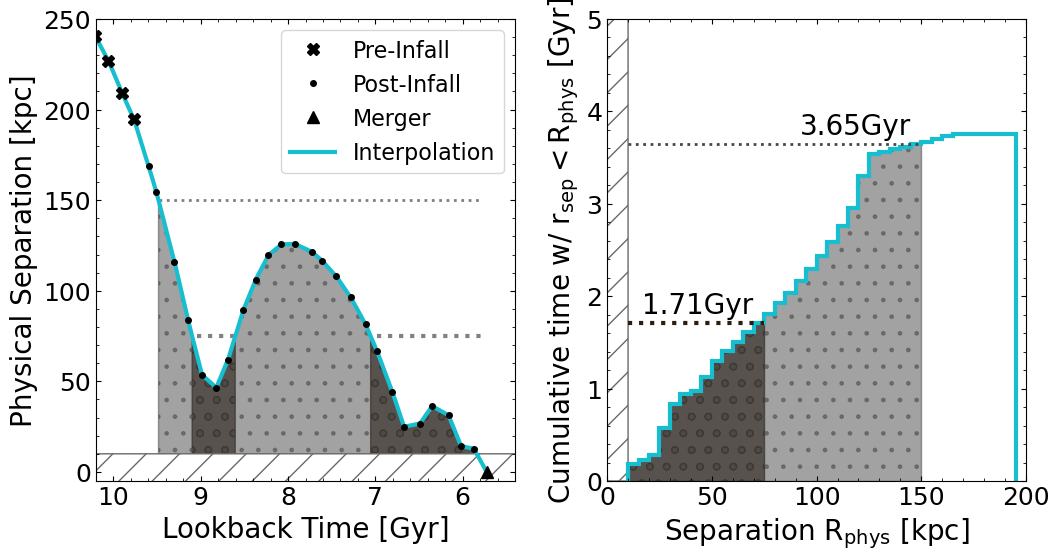

In [328]:
shade1 = "grey"
shade2 = "grey"

plot_lines = True
plot_shading = True


fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1],  
                                            'height_ratios':[1], 
                                            'wspace': 0.22, 
                                            "hspace":0.0})
 
# - shading & background lines - #
if plot_lines:
    ax[0].axhline(150, 0.15, 0.92, color=shade1, lw=lw['upper'], linestyle='dotted')
    ax[0].axhline(75, 0.67, 0.92, color=shade2, lw=lw['lower'], linestyle='dotted')
    ax[0].axhline(75, 0.24, 0.34, color=shade2, lw=lw['lower'], linestyle='dotted')
    
    ax[1].text(75-5,  upper_75[-2]+0.1, f'{upper_75[-2]:0.2f}Gyr', ha='right', color='black') 
    ax[1].axhline(upper_75[-2], 10/200, 75/200, color=palette['lower'], lw=lw['lower'], linestyle='dotted')

    ax[1].text(150-5, upper_150[-2]+0.1, f'{upper_150[-2]:0.2f}Gyr', ha='right', color='black') 
    ax[1].axhline(upper_150[-2], 10/200, 150/200, color=palette['upper'], lw=lw['upper'], linestyle='dotted')
    


if plot_shading:    
    ax[0].fill_between(times_masked, seps_75, seps_lower, color=palette['lower'], alpha=0.7, hatch='o') 
    ax[0].fill_between(times_masked, seps_150, seps_lower, color=palette['upper'], alpha=0.5, hatch='.')
    ax[0].fill_between(times_interp, -15, 10, facecolor="white", hatch='/', edgecolor='dimgrey') # <10 hatching

    ax[1].fill_between(edges_75, upper_75, 0, color=palette['lower'], alpha=0.7, hatch='o', step='post') 
    ax[1].fill_between(edges_150, upper_150, 0, color=palette['upper'], alpha=0.5, hatch='.', step='post') 
    ax[1].fill_betweenx(times_interp, 0, 10, facecolor="white", hatch='/', edgecolor='dimgrey') # <10 hatching

# - plot orbit - #
ax[0].plot(times_interp[pre_interp], seps_interp[pre_interp],  lw=3, color=palette['ex1'])  

ax[0].plot(times[~post], seps[~post], ms=8, marker='X', color='black', label='Pre-Infall', ls='')    
ax[0].plot(times[post&premerge], seps[post&premerge],  ms=8,  marker='.', color='black', label='Post-Infall', ls='')    
ax[0].plot(time_merge, 0,  ms=8,  marker='^', color='black', label='Merger', ls='')   

ax[0].plot(0, 0, lw=3, color=palette['ex1'], label='Interpolation')  

# - plot cumulative separation - #
ax[1].stairs(val_sum, edges=edges, lw=3, color=palette['ex1'])




# - styles - #
ax[0].set_ylabel("Physical Separation [kpc]")
ax[0].set_xlabel("Lookback Time [Gyr]")
ax[0].set_xlim(10.2, 5.4)  
ax[0].set_ylim(bottom=-5, top=250) 
ax[0].legend(fontsize=16)

ax[1].set_ylabel(r"Cumulative time w/ $\rm r_{sep}<R_{phys}$ [Gyr]")
ax[1].set_xlabel(r"Separation $\rm R_{phys}$ [kpc]")

ax[1].set_xlim(left=0, right=200) 
ax[1].set_ylim(top=5) 
# ax[1].legend(fontsize=16, title='Total time')

plt.savefig('../../plots/bet-on-it/4_example1.png')

plt.show()

# Cumulative example 2

In [329]:
sample = 154 

times = convert['Lookback Time']
seps = low['Separations'][sample]
post = low['PostInfall'][sample]
time_merge = convert['Lookback Time'][low['MergeSnapshot'][sample]]

premerge = convert['Lookback Time'] > time_merge


post_interp = low_interp['PostInfall'][sample]
times_interp = convert_interp["Lookback Time Interp"]
pre_interp = times_interp > time_merge
seps_interp = low_interp['Separations Interp'][sample]

times_masked = times_interp[post_interp&pre_interp]
seps_masked = seps_interp[post_interp&pre_interp]


seps_lower = np.where(seps_masked>=10,10,np.nan)
seps_100 = np.where( (seps_masked<=100 ) & (seps_masked>=10), seps_masked, np.nan)
seps_200 = np.where( (seps_masked<=200 ) & (seps_masked>=10), seps_masked, np.nan)

elapsed_interp = np.concatenate((np.abs(np.diff(times_masked)),[0]))

bins = np.arange(10,300,10)
vals, edges = np.histogram(seps_masked,bins=bins,weights=elapsed_interp)
val_sum = np.cumsum(vals)

upper_100 = val_sum[edges[:-1]<=100]
edges_100 = edges[edges<=100]
upper_200 = val_sum[edges[:-1]<=200]
edges_200 = edges[edges<=200]

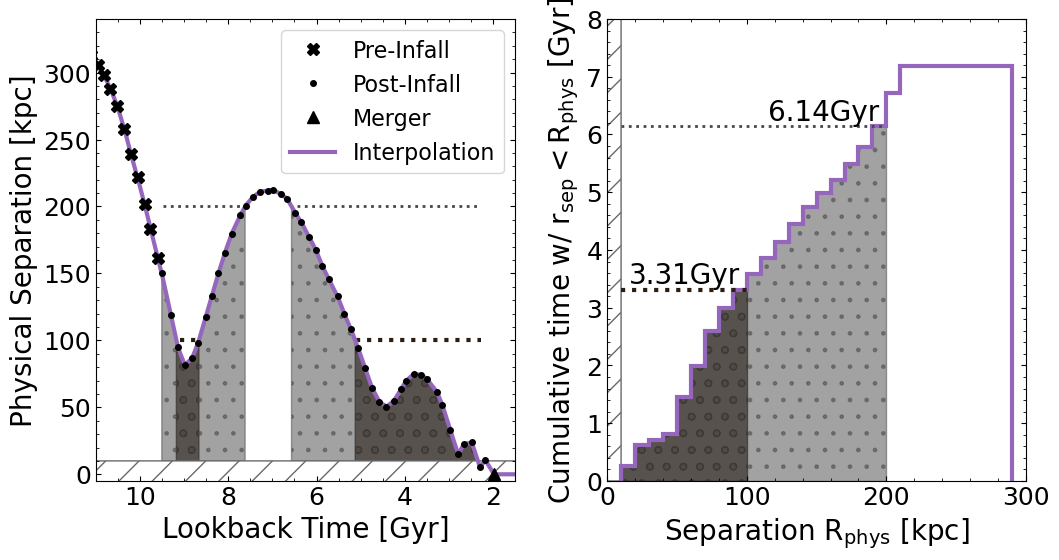

In [330]:

fig,ax = plt.subplots(1,2,figsize=(12,6),gridspec_kw={'width_ratios': [1,1], 
                                            'height_ratios':[1],
                                            'wspace': 0.22,
                                            "hspace":0.0})
 
# - shading & background lines - #
if plot_lines:
    ax[0].axhline(200, 0.48, 0.92, color=palette['upper'], lw=lw['upper'], linestyle='dotted')
    ax[0].axhline(200, 0.16, 0.35, color=palette['upper'], lw=lw['upper'], linestyle='dotted')
    ax[0].axhline(100, 0.62, 0.92, color=palette['lower'], lw=lw['lower'], linestyle='dotted')
    ax[0].axhline(100, 0.20, 0.24, color=palette['lower'], lw=lw['lower'], linestyle='dotted')
    
    ax[1].text(100-5, upper_100[-2]+0.1, f'{upper_100[-2]:0.2f}Gyr', ha='right', color='black') 
    ax[1].axhline(upper_100[-2], 10/300, 100/300, color=palette['lower'], lw=lw['lower'], linestyle='dotted')

    ax[1].text(200-5, upper_200[-2]+0.1, f'{upper_200[-2]:0.2f}Gyr', ha='right', color='black') 
    ax[1].axhline(upper_200[-2], 10/300, 200/300, color=palette['upper'], lw=lw['upper'], linestyle='dotted')
    
if plot_shading:    
    ax[0].fill_between(times_masked, seps_100, seps_lower, color=palette['lower'], alpha=0.7, hatch='o') 
    ax[0].fill_between(times_masked, seps_200, seps_lower, color=palette['upper'], alpha=0.5, hatch='.')
    ax[0].fill_between(times_interp, -15, 10, facecolor="white", hatch='/', edgecolor='dimgrey') # <10 hatching

    ax[1].fill_between(edges_100, upper_100, 0, color=palette['lower'], alpha=0.7, hatch='o', step='post') 
    ax[1].fill_between(edges_200, upper_200, 0, color=palette['upper'], alpha=0.5, hatch='.', step='post') 
    ax[1].fill_betweenx(times_interp, 0, 10, facecolor="white", hatch='/', edgecolor='dimgrey') # <10 hatching



# - plot orbit - #
ax[0].plot(times_interp ,seps_interp, lw=3, color=palette['ex2'])  

ax[0].plot(times[~post], seps[~post], ms=8, marker='X', color='black', label='Pre-Infall', ls='')    
ax[0].plot(times[post&premerge], seps[post&premerge], ms=8, marker='.', color='black', label='Post-Infall', ls='')    
ax[0].plot(time_merge, 0, ms=8, marker='^', color='black', label='Merger', ls='')   

ax[0].plot(0, 0, lw=3, color=palette['ex2'], label='Interpolation')  


# - plot cumulative separation - #
ax[1].stairs(val_sum, edges=edges, lw=3, color=palette['ex2'])


# - styles - #
ax[0].set_ylabel("Physical Separation [kpc]")
ax[0].set_xlabel("Lookback Time [Gyr]")
ax[0].set_xlim(11.,1.5)  
ax[0].set_ylim(bottom=-5,top=340) 
ax[0].legend(fontsize=16)

ax[1].set_ylabel(r"Cumulative time w/ $\rm r_{sep}<R_{phys}$ [Gyr]")
ax[1].set_xlabel(r"Separation $\rm R_{phys}$ [kpc]")
ax[1].set_xlim(left=0,right=300) 
ax[1].set_ylim(top=8) 
# ax[1].legend(fontsize=16,title='Total time')

plt.savefig('../../plots/bet-on-it/4_example2.png')

plt.show()

# Combined example

In [421]:
################
# First Example
################
sample = 55 
lower1 = 40
upper1 = 150

times = convert['Lookback Time']
seps = low['Separations'][sample]
post = low['PostInfall'][sample]
time_merge = convert['Lookback Time'][low['MergeSnapshot'][sample]]

premerge = convert['Lookback Time'] > time_merge

post_interp = low_interp['PostInfall'][sample]
times_interp = convert_interp["Lookback Time Interp"]
pre_interp = times_interp > time_merge
seps_interp = low_interp['Separations Interp'][sample]

times_masked = times_interp[post_interp&pre_interp]
seps_masked = seps_interp[post_interp&pre_interp]

seps_lower = np.where(seps_masked>=10,10,np.nan)
seps_75 = np.where( (seps_masked<=lower1 ) & (seps_masked>=10), seps_masked, np.nan)
seps_150 = np.where( (seps_masked<=upper1 ) & (seps_masked>=10), seps_masked, np.nan)

elapsed_interp = np.concatenate((np.abs(np.diff(times_masked)),[0]))

bins = np.arange(10,200,5)
bins = np.arange(10,300,10)
vals, edges = np.histogram(seps_masked,bins=bins,weights=elapsed_interp)
val_sum = np.cumsum(vals)

upper_75 = val_sum[edges[:-1]<=lower1]
edges_75 = edges[edges<=lower1]
upper_150 = val_sum[edges[:-1]<=upper1]
edges_150 = edges[edges<=upper1]

################
# Second Example
################
sample2 = 154 
lower2 = 100
upper2 = 200

times2 = convert['Lookback Time']
seps2 = low['Separations'][sample2]
post2 = low['PostInfall'][sample2]
time_merge2 = convert['Lookback Time'][low['MergeSnapshot'][sample2]]

premerge2 = convert['Lookback Time'] > time_merge2


post_interp2 = low_interp['PostInfall'][sample2]
times_interp2 = convert_interp["Lookback Time Interp"]
pre_interp2 = times_interp2 > time_merge2
seps_interp2 = low_interp['Separations Interp'][sample2]

times_masked2 = times_interp2[post_interp2&pre_interp2]
seps_masked2 = seps_interp2[post_interp2&pre_interp2]


seps_lower2 = np.where(seps_masked2>=10,10,np.nan)
seps_100 = np.where( (seps_masked2<=lower2 ) & (seps_masked2>=10), seps_masked2, np.nan)
seps_200 = np.where( (seps_masked2<=upper2 ) & (seps_masked2>=10), seps_masked2, np.nan)

elapsed_interp2 = np.concatenate((np.abs(np.diff(times_masked2)),[0]))

bins2 = np.arange(10,300,10)
vals2, edges2 = np.histogram(seps_masked2,bins=bins2,weights=elapsed_interp2)
val_sum2 = np.cumsum(vals2)

upper_100 = val_sum2[edges2[:-1]<=lower2]
edges_100 = edges2[edges2<=lower2]
upper_200 = val_sum2[edges2[:-1]<=upper2]
edges_200 = edges2[edges2<=upper2]

In [422]:
plot_lines = True
plot_shading = True
label_times = True

In [423]:
seps_75

array([nan, nan, nan, ..., nan, nan, nan])

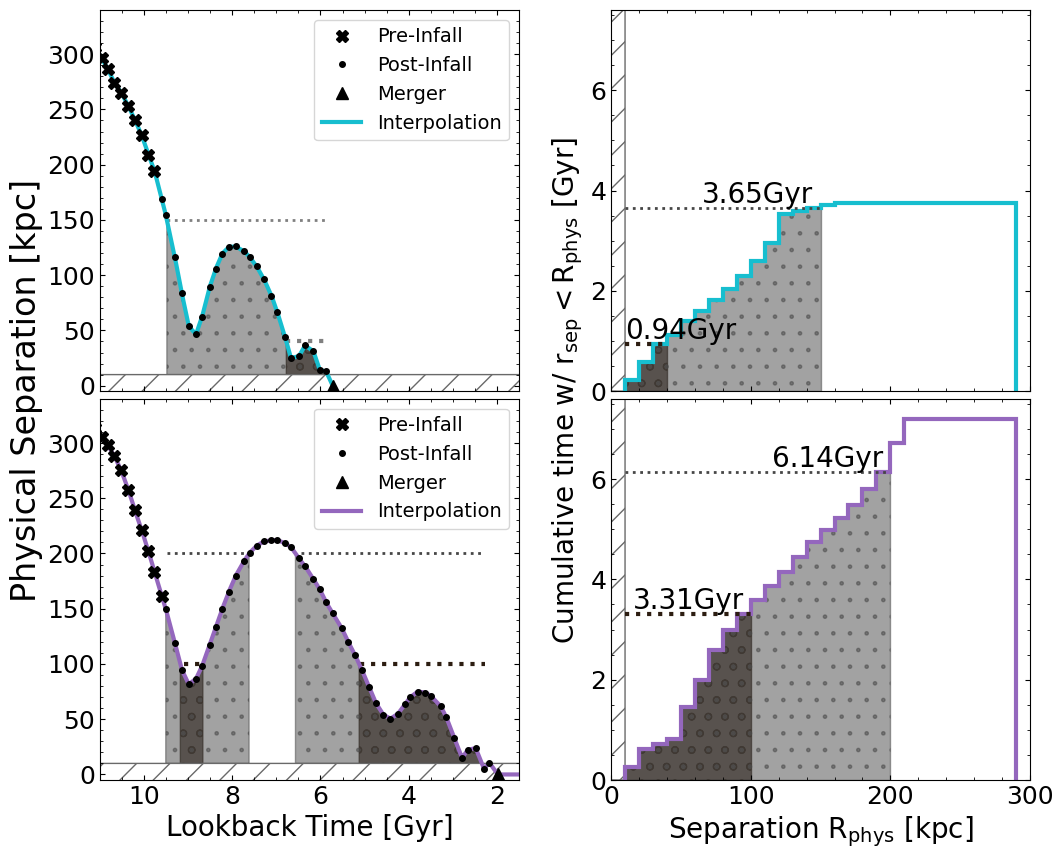

In [424]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10),sharex='col',sharey='col', gridspec_kw={'width_ratios': [1, 1],  
                                            'height_ratios':[1,1], 
                                            'wspace': 0.22, 
                                            "hspace":0.02})

 
# - shading & background lines - #
if plot_lines:
    percents_lower = ((-times_masked[~np.isnan(seps_75)])+11)/9.5
    percents_upper = ((-times_masked[~np.isnan(seps_150)])+11)/9.5

    lstart_upper1,lstart_lower1 = percents_upper[0],percents_lower[0]
    lend_upper1,lend_lower1 = percents_upper[-1],percents_lower[-1]

    ax[0][0].axhline(upper1, lstart_upper1,lend_upper1, color=shade1, lw=lw['upper'], linestyle='dotted')
    ax[0][0].axhline(lower1, lstart_lower1, lend_lower1, color=shade2, lw=lw['lower'], linestyle='dotted')
    ax[0][1].axhline(upper_75[-2], 10/300, lower1/300, color=palette['lower'], lw=lw['lower'], linestyle='dotted')
    ax[0][1].axhline(upper_150[-2], 10/300, upper1/300, color=palette['upper'], lw=lw['upper'], linestyle='dotted')
    
    ax[1][0].axhline(200, 0.48, 0.92, color=palette['upper'], lw=lw['upper'], linestyle='dotted')
    ax[1][0].axhline(200, 0.16, 0.35, color=palette['upper'], lw=lw['upper'], linestyle='dotted')
    ax[1][0].axhline(100, 0.62, 0.92, color=palette['lower'], lw=lw['lower'], linestyle='dotted')
    ax[1][0].axhline(100, 0.20, 0.24, color=palette['lower'], lw=lw['lower'], linestyle='dotted')
    
    ax[1][1].axhline(upper_100[-2], 10/300, lower2/300, color=palette['lower'], lw=lw['lower'], linestyle='dotted')
    ax[1][1].axhline(upper_200[-2], 10/300, upper2/300, color=palette['upper'], lw=lw['upper'], linestyle='dotted')


if plot_shading:    
    ax[0][0].fill_between(times_masked, seps_75, seps_lower, color=palette['lower'], alpha=0.7, hatch='o') 
    ax[0][0].fill_between(times_masked, seps_150, seps_lower, color=palette['upper'], alpha=0.5, hatch='.')
    ax[0][0].fill_between(times_interp, -15, 10, facecolor="white", hatch='/', edgecolor='dimgrey') # <10 hatching

    ax[0][1].fill_between(edges_75, upper_75, 0, color=palette['lower'], alpha=0.7, hatch='o', step='post') 
    ax[0][1].fill_between(edges_150, upper_150, 0, color=palette['upper'], alpha=0.5, hatch='.', step='post') 
    ax[0][1].fill_betweenx(times_interp, 0, 10, facecolor="white", hatch='/', edgecolor='dimgrey') # <10 hatching

    ax[1][0].fill_between(times_masked2, seps_100, seps_lower2, color=palette['lower'], alpha=0.7, hatch='o') 
    ax[1][0].fill_between(times_masked2, seps_200, seps_lower2, color=palette['upper'], alpha=0.5, hatch='.')
    ax[1][0].fill_between(times_interp2, -15, 10, facecolor="white", hatch='/', edgecolor='dimgrey') # <10 hatching

    ax[1][1].fill_between(edges_100, upper_100, 0, color=palette['lower'], alpha=0.7, hatch='o', step='post') 
    ax[1][1].fill_between(edges_200, upper_200, 0, color=palette['upper'], alpha=0.5, hatch='.', step='post') 
    ax[1][1].fill_betweenx(times_interp2, 0, 10, facecolor="white", hatch='/', edgecolor='dimgrey') # <10 hatching
    
if label_times:  
    ax[0][1].text(75+15,  upper_75[-2]+0.1, f'{upper_75[-2]:0.2f}Gyr', ha='right', color='black') 
    ax[0][1].text(150-5, upper_150[-2]+0.1, f'{upper_150[-2]:0.2f}Gyr', ha='right', color='black') 
    ax[1][1].text(100-5, upper_100[-2]+0.1, f'{upper_100[-2]:0.2f}Gyr', ha='right', color='black') 
    ax[1][1].text(200-5, upper_200[-2]+0.1, f'{upper_200[-2]:0.2f}Gyr', ha='right', color='black') 

# - plot orbit - #
ax[0][0].plot(times_interp[pre_interp], seps_interp[pre_interp],  lw=3, color=palette['ex1'])  
ax[1][0].plot(times_interp2, seps_interp2, lw=3, color=palette['ex2'])  

# - plot discrete points - #
ax[0][0].plot(times[~post], seps[~post], ms=8, marker='X', color='black', label='Pre-Infall', ls='')    
ax[0][0].plot(times[post&premerge], seps[post&premerge],  ms=8,  marker='.', color='black', label='Post-Infall', ls='')    
ax[0][0].plot(time_merge, 0,  ms=8,  marker='^', color='black', label='Merger', ls='')   

ax[1][0].plot(times2[~post2], seps2[~post2], ms=8, marker='X', color='black', label='Pre-Infall', ls='')    
ax[1][0].plot(times2[post2&premerge2], seps2[post2&premerge2], ms=8, marker='.', color='black', label='Post-Infall', ls='')    
ax[1][0].plot(time_merge2, 0, ms=8, marker='^', color='black', label='Merger', ls='')  

# - plot labels - #
ax[0][0].plot(0, 0, lw=3, color=palette['ex1'], label='Interpolation')  
ax[1][0].plot(0, 0, lw=3, color=palette['ex2'], label='Interpolation')  

# - plot cumulative separation - #
ax[0][1].stairs(val_sum, edges=edges, lw=3, color=palette['ex1'])
ax[1][1].stairs(val_sum2, edges=edges2, lw=3, color=palette['ex2'])

# - styles - #
# ax[0][0].set_ylabel("Physical Separation [kpc]")
# ax[0][0].set_xlabel("Lookback Time [Gyr]")
# ax[0][0].set_xlim(10.2, 5.4)  
# ax[0][0].set_ylim(bottom=-5, top=250) 


# ax[0][1].set_ylabel(r"Cumulative time w/ $\rm r_{sep}<R_{phys}$ [Gyr]")
# ax[0][1].set_xlabel(r"Separation $\rm R_{phys}$ [kpc]")

ax[0][1].set_xlim(left=0, right=200) 
ax[0][1].set_ylim(top=5) 
ax[1][0].set_xlim(11.,1.5)  
ax[1][0].set_ylim(bottom=-5,top=340) 
ax[1][1].set_xlim(left=0,right=300) 
ax[1][1].set_ylim(top=7.6) 


# ax[1][0].set_ylabel("Physical Separation [kpc]")


ax[0][0].legend(fontsize=14)
ax[1][0].legend(fontsize=14)

ax[1][0].set_xlabel("Lookback Time [Gyr]")
ax[1][1].set_xlabel(r"Separation $\rm R_{phys}$ [kpc]")

fig.supylabel("Physical Separation [kpc]",x=0.05)
fig.text(x=0.5,y=0.5,s=r"Cumulative time w/ $\rm r_{sep}<R_{phys}$ [Gyr]",rotation='vertical',va='center')
# fig.supylabel(r"Cumulative time w/ $\rm r_{sep}<R_{phys}$ [Gyr]",x=0.55)
plt.savefig('../../plots/bet-on-it/4_examplecombo.png')

plt.show()